### Generating human faces with Adversarial Networks
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/nvidia_cool_gan.png?raw=1" width="400px"/>
_© research.nvidia.com_

This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .


In [0]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week3()
setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

# If you're using the old version of the course (check a path of notebook on Coursera, you'll see v1 or v2),
# use setup_week2_old().

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2019-01-21 06:37:38--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.70K  --.-KB/s    in 0s      

2019-01-21 06:37:38 (39.0 MB/s) - ‘setup_google_colab.py’ saved [3792/3792]

**************************************************
lfw-deepfunneled.tgz
**************************************************
lfw.tgz
**************************************************
lfw_attributes.txt


In [0]:
1

1

In [0]:
import sys
sys.path.append("..")
import grading
import download_utils
import tqdm_utils

In [0]:
download_utils.link_week_4_resources()

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import load_lfw_dataset 
data,attrs = load_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

**************************************************



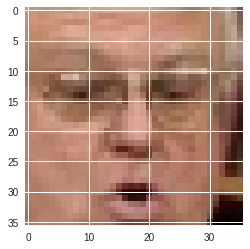

In [31]:
#print random image
# объект data - 4-ех мерный Тензор. (Batch_size x width x height x 3) = (13143, 36, 36, 3). Лейблов нет, так как здесь не задача классификации
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/noise_to_face.png?raw=1" width="400px"/>
_© torch.github.io_

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [0]:
import tensorflow as tf
from keras_utils import reset_tf_session
s = reset_tf_session()

import keras
from keras.models import Sequential
from keras import layers as L

In [0]:
CODE_SIZE = 256 # размерность шума

# Отедльно создаем генератор:
generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))


In [34]:
# Проверяем, что output_shape совпадает с размерностью одной картинки из датасета
generator.output_shape

(None, 36, 36, 3)

In [37]:
generator.layers[-2].output_shape

(None, 38, 38, 32)

In [0]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [0]:
discriminator = Sequential()
from keras.layers import LeakyReLU

discriminator.add(L.InputLayer(IMG_SHAPE))

# Отдельная сеть для дискриминатора:

# --------------МОЯ ВЕРСИЯ----------------------------------------
# #<build discriminator body>
# discriminator.add(L.Conv2D(4, 4, activation='relu', padding='same'))
# discriminator.add(L.MaxPool2D())
# discriminator.add(L.Conv2D(16, 3, activation='relu', padding='same'))
# discriminator.add(L.MaxPool2D())
# discriminator.add(L.Conv2D(32, 3, activation='relu', padding='same'))
# discriminator.add(L.MaxPool2D())
# discriminator.add(L.Conv2D(64, 3, activation='relu', padding='same'))
# discriminator.add(L.MaxPool2D())
# discriminator.add(L.Conv2D(128, 3, activation='relu', padding='same'))
# discriminator.add(L.MaxPool2D())
# ---------------ВЕРСИЯ_из_GITHUB-----------------------------------------
discriminator.add(L.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2), strides=None))
discriminator.add(L.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2), strides=None))
discriminator.add(L.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2), strides=None))
discriminator.add(L.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2), strides=None))



discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
# последний слой - log_softmax, это log от softmax
# Доказательство: https://stackoverflow.com/questions/49236571/what-is-the-difference-between-softmax-and-log-softmax
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))


In [39]:
discriminator.layers[4].input_shape

(None, 18, 18, 32)

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/gan.png?raw=1" width="600px"/>
_© deeplearning4j.org_

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


Используем формулы:

![Image of Yaktocat](https://pp.userapi.com/c846324/v846324268/17fc64/K-sBOhfm8r8.jpg)


In [0]:
noise = tf.placeholder('float32',[None,CODE_SIZE]) # Это placeholder шума, его мы будем подавать внутрь session.run(..., {noise: ...})
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE)) # аналогично с предыдущим

# Далее договариваемся, что Disc выдает вектор размерностью (1, 2), где 1-ое число: P(fake), второе число: P(real)
# То есть log_softmax(dis(realdata)) = P(fake)
# log_softmax(1 - dis(realdata)) = P(real)
logp_real = discriminator(real_data) # Поскольку мы в последнем слое прописали log_softmax, то в этой строчке мы получили [log_softmax(dis(realdata)), log_softmax(1 - dis(realdata))]

# <gen(noise)>
generated_data = generator(noise) # Генерим рандомную картинку

# <log P(real | gen(noise))>
logp_gen = discriminator(generated_data) # Применяем дискриминатор к сгенерированной картинке.  Получим [log_softmax(dis(fake)), log_softmax(1 - dis(fake))]

In [0]:
logp_gen.shape

TensorShape([Dimension(None), Dimension(2)])

In [0]:
logp_real.shape

TensorShape([Dimension(None), Dimension(2)])

In [0]:
np.arange(10).reshape((2,5))[:,1]

array([1, 6])

In [0]:
logp_gen.shape

TensorShape([Dimension(None), Dimension(2)])

In [0]:
########################
#discriminator training#
########################

# см картинку выше: L_D = -mean(log_softmax(1 - dis(realdata)) + log_softmax(dis(fake)))
# соответсвенно, так как logp_real и logp_gen имеют размерность (1, 2), то у logp_real берем второй элемент, а у logp_gen нулевой
d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
# Регуляризация последнего слоя
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

In [0]:
########################
###generator training###
########################

# <generator loss>
# соответсвенно, так как logp_gen имеет размерность (1, 2), то берем 2-ой элемент, то есть - mean( 1 - discriminator(generated_data) )
g_loss = -tf.reduce_mean(logp_gen[:,1])
#g_loss = 

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

    

In [0]:
s.run(tf.global_variables_initializer())

### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [0]:
def sample_noise_batch(bsize):
    # генерит рандомный шум размерностью (batch, CODE_SIZE)
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    # возвращаем случайно выбранные bsize картинок
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    # Случайным образом генерим шум nrow*ncol раз, после чего генератором генерим изображения и отрисовываем
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    # Рисуем гистограмму Генератора и Дискриминатора
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Только ЕСЛИ уже есть предобученные модели, которые, например, лежат в google drive:
from keras.models import load_model
discriminator = load_model('gdrive/My Drive/Temp/discriminator_30000.h5', custom_objects={'log_softmax': tf.nn.log_softmax})
generator = load_model('gdrive/My Drive/Temp/generator_30000.h5', custom_objects={'log_softmax': tf.nn.log_softmax})

/usr/local/lib/python3.6/dist-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


48800


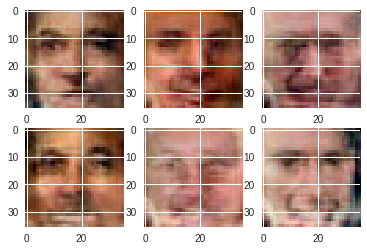

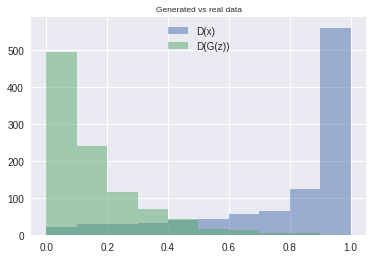

KeyboardInterrupt: ignored

In [26]:
from IPython import display

for epoch in tqdm_utils.tqdm_notebook_failsafe(range(50000)):
    # каждую эпоху генерим по 100 реальных и сгенерированных картинок
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5): # 5 раз прогоняем и обучаем Discr 
        s.run(disc_optimizer,feed_dict)
    
    # 1 раз обучаем генератор
    # елси что, в него можно не весь feed_dict, а только noise компоненту подавать
    s.run(gen_optimizer, feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)
        print(epoch)
        sample_images(2,3,True)# раз в 100 эпох отрисовываем 2*3 сгененрированных изображений 
        sample_probas(1000) # Выбираем и генерим по 1000 изображений, предсказываем с помощью Discr, рисуем получившуюся гистограмму
    if epoch % 10000 == 0:
      discriminator.save('gdrive/My Drive/discriminator_{}.h5'.format(epoch))
      generator.save('gdrive/My Drive/generator_{}.h5'.format(epoch))
        

In [0]:
epoch

35

In [0]:
# мой кусок, чтобы созранить обученные модели:
discriminator.save('discriminator.h5')
generator.save('generator.h5')

In [0]:
from submit_honor import submit_honor
submit_honor((generator, discriminator), 'dmitryhse@gmail.com', 'X9P5BtTZDTPGgNWP')

Submitted to Coursera platform. See results on assignment page!


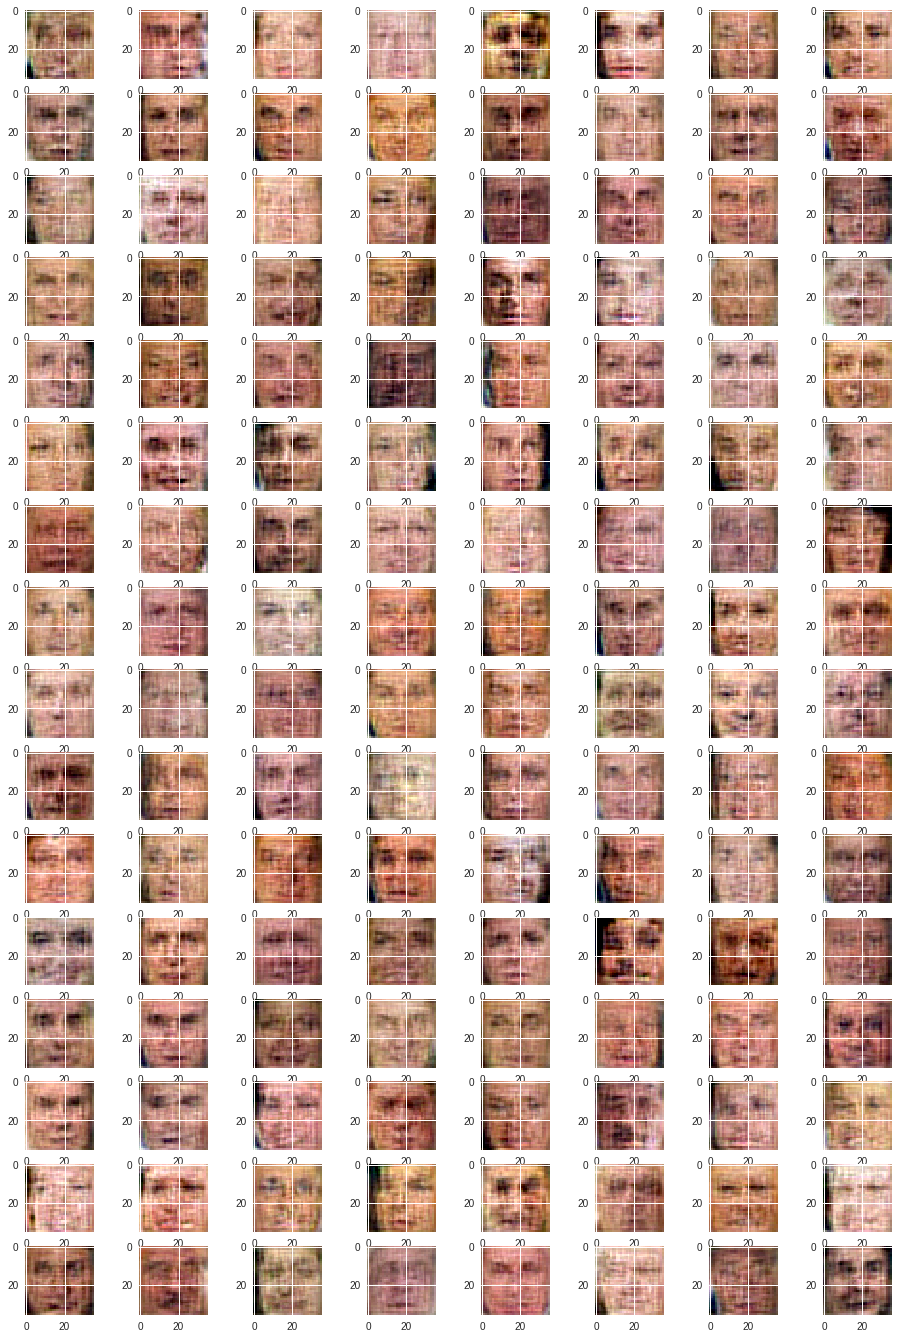

In [0]:
#The network was trained for about 15k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[16,24])
sample_images(16,8)